In [1]:
%pip install scikit-learn

import src.spectral_utils as su
import src.graph_utils as gu
from src.DetectionResult import DetectionResult
from src.simgraph import SimGraph, from_file

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

#function to extract the forensic similarity matrix from a .simg file
def simg2mat(ff):
    mat = from_file(ff).mat
    return mat

#aggregate sim matrices by directroy
#glist (Graph List) is a list of tuples [(file_path, similarity_matrix),...]
def dir2glist(fdir,ftype='*.simg'):
    flist = glob(fdir+ftype)
    glist = [(os.path.basename(ff),simg2mat(ff)) for ff in flist]
    return glist

Note: you may need to restart the kernel to use updated packages.


In [2]:
def spec_gap_detection_result(glist_auth, glist_splc,
                              laplacian_type = None,
                              notes='', test_name=''):
    #%% Calculate Gap
    aL = [su.laplacian(g[1],laplacian_type=laplacian_type) for g in glist_auth]
    sL = [su.laplacian(g[1],laplacian_type=laplacian_type) for g in glist_splc]
    aG = np.array([su.eigap01(L) for L in aL])
    sG = np.array([su.eigap01(L) for L in sL])

    param_dict = {'type':'Spectral Gap','Normalization':laplacian_type,
                  'notes':notes,'test':test_name}

    #-1 is important since small gap indicates more likely to be tampered
    gap_dr = DetectionResult(-1*aG,-1*sG, result_type='specgap', label='Spectral Gap', parameters=param_dict)
    
    return gap_dr

def mod_opt_detection_result(glist_auth, glist_splc,
                             mod_thresh = 0.0, mod_weighted = True,
                             notes='', test_name=''):
    #%%fast greedy
    list_smod = gu.glist_to_fastgreedy_modularity(glist_splc,threshold=mod_thresh,weighted=mod_weighted)
    list_amod = gu.glist_to_fastgreedy_modularity(glist_auth,threshold=mod_thresh,weighted=mod_weighted)
    aMod = np.array(list_amod)
    sMod = np.array(list_smod)

    param_dict = {'type':'Fast Greedy Modularity Optimization',
                  'Threshold':mod_thresh, 'Weighted':mod_weighted,
                  'notes':notes,'test':test_name}

    mod_dr = DetectionResult(aMod,sMod,result_type='modopt',label='Modularity Optimization',parameters=param_dict)
    
    return mod_dr

def min_detection_result(glist_auth, glist_splc,
                         notes='', test_name=''):
    #MINIMUM
    aMin = [np.percentile(g[1].ravel(),0) for g in glist_auth]
    sMin = [np.percentile(g[1].ravel(),0) for g in glist_splc]
    param_dict = {'type':'Minimum Similarity',
                  'notes':notes,'test':test_name}

    min_dr = DetectionResult(-1*np.array(aMin),-1*np.array(sMin),result_type='min',label='Min Similarity',parameters=param_dict)
    return min_dr
    
def mean_detection_result(glist_auth, glist_splc,
                          notes='', test_name=''):
    #MEAN
    aMean = [np.mean(g[1].ravel()) for g in glist_auth]
    sMean = [np.mean(g[1].ravel()) for g in glist_splc]

    param_dict = {'type':'Mean Similarity',
                  'notes':notes,'test':test_name}

    mean_dr = DetectionResult(-1*np.array(aMean),-1*np.array(sMean),result_type='mean',label='Mean Similarity',parameters=param_dict)
    
    return mean_dr

In [3]:
#%%
dir_top = './simg_saves/cam_256/128/'

#dir_splc = os.path.join(dir_top,'4cam_splc/')
#dir_auth = os.path.join(dir_top,'4cam_auth/')

dir_splc = os.path.join(dir_top,'carvalho_tampered/')
dir_auth = os.path.join(dir_top,'carvalho_pristine/')

#dir_splc = os.path.join(dir_top,'korus_tampered/')
#dir_auth = os.path.join(dir_top,'korus_pristine/')
    
glist_auth = dir2glist(dir_auth)
glist_splc = dir2glist(dir_splc)

In [4]:
print('Computing Spectral Gap detection statistics')
gap_dr = spec_gap_detection_result(glist_auth, glist_splc)

print('Computing Modularity Optimization detection statistics')
mod_dr = mod_opt_detection_result(glist_auth, glist_splc)

print('Computing Minimum Similarity detection statistics')
min_dr = min_detection_result(glist_auth, glist_splc)

print('Computing Mean Similarity detection statistics')
mean_dr = mean_detection_result(glist_auth, glist_splc)

Computing Spectral Gap detection statistics
Computing Modularity Optimization detection statistics
Computing Minimum Similarity detection statistics
Computing Mean Similarity detection statistics


In [5]:
print(f'mAP, Spectral Gap: {gap_dr.calc_map()}')
print(f'mAP, Modularity Opt: {mod_dr.calc_map()}')
print(f'mAP, Min Sim: {min_dr.calc_map()}')
print(f'mAP, Mean Sim: {mean_dr.calc_map()}')

mAP, Spectral Gap: 0.9694533084052369
mAP, Modularity Opt: 0.9451803743848715
mAP, Min Sim: 0.9631442966835694
mAP, Mean Sim: 0.9452029640978102


In [6]:
print(f'Pd@Pfa=0.01, Spectral Gap: {gap_dr.calc_pd_at_pfa(0.01)}')
print(f'Pd@Pfa=0.01, Modularity Opt: {mod_dr.calc_pd_at_pfa(0.01)}')
print(f'Pd@Pfa=0.01, Min Sim: {min_dr.calc_pd_at_pfa(0.01)}')
print(f'Pd@Pfa=0.01, Mean Sim: {mean_dr.calc_pd_at_pfa(0.01)}')

Pd@Pfa=0.01, Spectral Gap: 0.8
Pd@Pfa=0.01, Modularity Opt: 0.38
Pd@Pfa=0.01, Min Sim: 0.75
Pd@Pfa=0.01, Mean Sim: 0.51


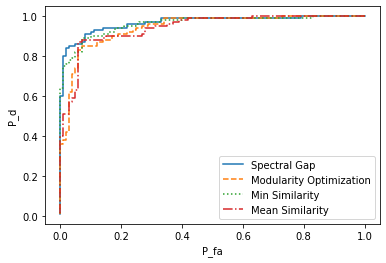

In [7]:
f,ax = plt.subplots(1)
_,h = gap_dr.plot_roc(ax=ax)
_,h = mod_dr.plot_roc(ax=ax)
h[0].set_linestyle('--')
_,h = min_dr.plot_roc(ax=ax)
h[0].set_linestyle(':')
_,h = mean_dr.plot_roc(ax=ax)
h[0].set_linestyle('-.')
plt.legend()
plt.xlabel('P_fa')
plt.ylabel('P_d')
plt.show()